## Import Packages

In [348]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import svm
from sklearn.model_selection import train_test_split
import hdbscan
from sklearn.manifold import TSNE
import seaborn as sns

## Import Datasets

In [2]:
connectivity_data = np.genfromtxt('Cowork data-20210221/COBRE_fmri_connectivity.csv', delimiter=',')
demographics = pd.read_csv('Cowork data-20210221/COBRE_demographics.csv')
regions = pd.read_csv('Cowork data-20210221/COBRE_fmri_regions.csv')
thickness = pd.read_csv('Cowork data-20210221/COBRE_cortical_thickness.csv')

## Preprocess/Reformat Data

In [3]:
#Reshape matrix to be 3d
cd = np.zeros([connectivity_data.shape[0], 293, 293])
i = 0
for row in connectivity_data:
    cd[i] = (np.reshape(row,[293,293]))
    i+=1

In [4]:
#Remove regions not in 293
x = thickness.columns.tolist()
for i in range(0,len(x)):
    x[i] = x[i].split('_thickness')[0]
thickness.columns = x
thickness = thickness[regions['Region_name'].to_list()]

In [5]:
#Fill NANs with 0
demographics['PANSS_total'] = demographics['PANSS_total'].fillna(0)

In [6]:
schiz = np.where(demographics['labels'] == 1)
noSchiz = np.where(demographics['labels'] == -1)
cdSchiz = cd[schiz]
cdNoSchiz = cd[noSchiz]
cdFullSchiz = connectivity_data[schiz]

## Reduce Dimensionality with PCA or CCA

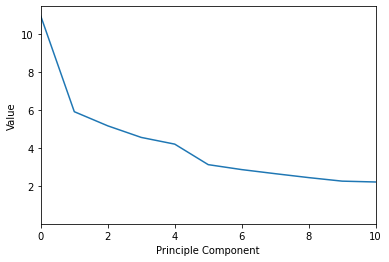

In [100]:
u,s,vh = np.linalg.svd(cd[0])
plt.xlim(0,10)
plt.ylabel('Value')
plt.xlabel('Principle Component')
plt.plot(s)

[0.04928666869926218, 0.04970292813911701, 0.05012713745439301, 0.050564890468540756, 0.05111477492344209, 0.05166521467782496, 0.05223214352637655, 0.05288918754095523, 0.053652282312125044, 0.05453123512250542, 0.05555978883427411, 0.05737826174789283, 0.05944470602084341, 0.062001142290425255, 0.06519793993865164]


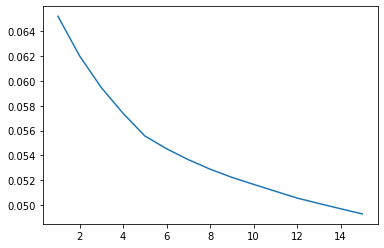

In [9]:
def rmse(A,Ahat):
    Atilde=A-Ahat
    Atilde=Atilde*Atilde #elementwise multiplication
    (n,m)=Atilde.shape
    mse=sum(sum(Atilde))/(n*m)
    return np.sqrt(mse)
            

numPCs=range(15,0,-1)
u,s,vh = np.linalg.svd(cd[0])
lenS=len(s)
rmses=[]
for numPC in numPCs:
    s[numPC:]=np.zeros(lenS-numPC)
    Sigma=np.zeros((u.shape[0],lenS))
    Sigma[:lenS,:]=np.diag(s)
    foodRecon=u@Sigma@vh
    rmses.append(rmse(foodRecon,cd[0]))
print(rmses)
plt.plot(numPCs,rmses)

In [10]:
reducedSchiz = PCA(n_components=5).fit_transform(cdFullSchiz)

In [38]:
reducedAll = PCA(n_components=5).fit_transform(connectivity_data)

## Prove Schiz and No Schiz is Separable

## Using SVMs

In [303]:
y = demographics['labels']
X_train, X_test, y_train, y_test = train_test_split(reducedAll, y, test_size=0.31, random_state=42)
y_test = np.array(y_test)

In [304]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(102, 5) (46, 5) (102,) (46,)


In [305]:
clf = svm.SVC(C=.2, kernel='rbf')
clf.fit(X_train, y_train)
res = clf.predict(X_test)
same = res == y_test
print(clf.score(X_test, y_test))

0.8043478260869565


In [130]:
print(res, '\n', y_test)

[ 1  1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1  1 -1  1
  1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1  1  1 -1  1  1 -1 -1 -1] 
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1
 -1 -1 -1 -1 -1  1  1  1 -1 -1  1  1 -1  1  1 -1  1  1  1 -1 -1]


# Using K-Means

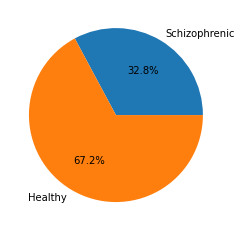

In [104]:
kmeans=KMeans(n_clusters=2)
s=kmeans.fit(reducedSchiz)
labels=kmeans.labels_
centroid=kmeans.cluster_centers_
labels=list(labels)
percent=[]
for i in range(len(centroid)):
    j=labels.count(i)
    j=j/(len(labels))
    percent.append(j)
plt.pie(percent,labels=['Schizophrenic', 'Healthy'], autopct='%1.1f%%')
plt.show()

schizLabs = kmeans.labels_

In [12]:
schizLabs = np.where(schizLabs==0)[0].tolist()
schiz = schiz[0].tolist()

In [13]:
print("Percent accuracy or Schizophrenia or not:", round(100-len(np.intersect1d(schiz, schizLabs))/len(schiz)*100, 2))

Percent accuracy or Schizophrenia or not: 86.57


## Apply K-Means Clustering With Elbow Method to Determine Number of Clusters

In [112]:
def cluster(data):
    md=[]
    for i in range(1,11): #TODO Tuning parameter
        kmeans=KMeans(n_clusters=i)
        kmeans.fit(data)
        o=kmeans.inertia_
        md.append(o)
    print(md)

    plt.plot(list(np.arange(1,11)),md) 
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show()

    nClusters = 0
    rate = [t - s for s, t in zip(md, md[1:])]
    for i in range(0,len(rate)-1):
        if abs(rate[i]) < 2*abs(rate[i+1]): #TODO Tuning parameter
            nClusters = i+2
            break
    print("Number of Clusters Detected:", nClusters)
    
    kmeans=KMeans(n_clusters=nClusters)
    s=kmeans.fit(data)
    labels=kmeans.labels_
    centroid=kmeans.cluster_centers_
    labels=list(labels)
    percent=[]
    for i in range(len(centroid)):
        j=labels.count(i)
        j=j/(len(labels))
        percent.append(j)
    plt.pie(percent,labels=['Subtype 0', 'Subtype 1', 'Subtype 2'], autopct='%1.1f%%')
    plt.show()

    kmeans.labels_
    return kmeans.labels_

In [15]:
(connectivity_data.shape, cdFullSchiz.shape, reducedSchiz.shape)

((148, 85849), (67, 85849), (67, 5))

[11086.798614021292, 4870.0605085894285, 3636.1333427906934, 3009.259330577828, 2612.83798299462, 2284.1899563813417, 1999.2630527238307, 1803.136023041931, 1580.6617865003464, 1362.6940795685614]


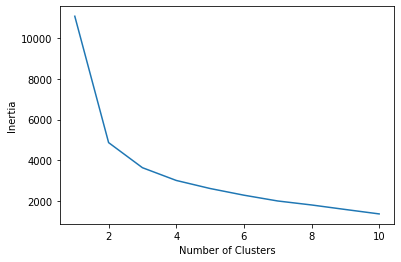

Number of Clusters Detected: 3


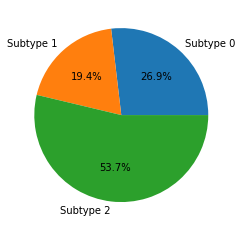

In [113]:
labels = cluster(reducedSchiz)

## Soft/Fuzzy Clustering, Diagnoses should be more fluid rather than hard disctinction

In [341]:
data = reducedSchiz
projection = TSNE().fit_transform(data)
data.shape

(67, 5)

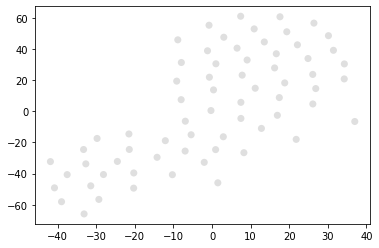

In [347]:
#The data does not cluster well in 2 dimensions, so it is hard to visualize the graph
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True).fit(data)
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)